<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/Kopie_for_variant_2_BAF_Exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [2]:
#!git clone https://github.com/MDankloff/Cluster-Bias-Disco.git
#!cd Cluster-Bias-Disco/
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install dask[dataframe]

In [4]:
import pickle
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import glob
import os
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.utils import resample

# Load data and Best LightGBM Models

Sets of features (data columns)

In [5]:
#MASTER DATASET

META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = ['payment_type', 'days_since_request', 'bank_branch_count_8w', 'credit_risk_score', 'source', 'device_os','month', 'session_length_in_minutes',
      'velocity_6h', 'velocity_24h', 'velocity_4w', 'email_is_free', 'proposed_credit_limit', 'keep_alive_session', 'intended_balcon_amount', 'name_email_similarity',
      'prev_address_months_count', 'current_address_months_count', 'zip_count_4w', 'date_of_birth_distinct_emails_4w',
      'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'foreign_request',
      'device_distinct_emails', 'device_fraud_count']

#REG = ['payment_type', 'days_since_request', 'bank_branch_count_8w', 'credit_risk_score', 'source', 'device_os','month', 'session_length_in_minutes',
       #'velocity_6h', 'velocity_24h', 'velocity_4w', 'email_is_free', 'proposed_credit_limit', 'keep_alive_session', 'intended_balcon_amount']

SEN = ['customer_age', 'income', 'employment_status'] #protected attributes in BAF paper

#PROX = ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'zip_count_4w', 'date_of_birth_distinct_emails_4w',
        #'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'foreign_request',
        #'device_distinct_emails', 'device_fraud_count']

SHAP_REG = ['SHAP_payment_type', 'SHAP_days_since_request', 'SHAP_bank_branch_count_8w', 'SHAP_credit_risk_score', 'SHAP_source', 'SHAP_device_os','SHAP_month',
            'SHAP_session_length_in_minutes', 'SHAP_velocity_6h', 'SHAP_velocity_24h', 'SHAP_velocity_4w', 'SHAP_email_is_free', 'SHAP_proposed_credit_limit',
            'SHAP_keep_alive_session', 'SHAP_intended_balcon_amount', 'SHAP_name_email_similarity',
      'SHAP_prev_address_months_count', 'SHAP_current_address_months_count', 'SHAP_zip_count_4w', 'SHAP_date_of_birth_distinct_emails_4w',
      'SHAP_housing_status', 'SHAP_phone_home_valid', 'SHAP_phone_mobile_valid', 'SHAP_bank_months_count', 'SHAP_has_other_cards', 'SHAP_foreign_request',
      'SHAP_device_distinct_emails', 'SHAP_device_fraud_count']

SHAP_DUMMY = ['']


################################## SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['payment_type_scaled', 'days_since_request_scaled', 'bank_branch_count_8w_scaled', 'credit_risk_score_scaled',
              'source_scaled', 'device_os_scaled','month_scaled', 'session_length_in_minutes_scaled',
              'velocity_6h_scaled', 'velocity_24h_scaled', 'velocity_4w_scaled', 'email_is_free_scaled', 'proposed_credit_limit_scaled', 'keep_alive_session_scaled','intended_balcon_amount_scaled']
SEN_scaled = ['customer_age_scaled', 'income_scaled', 'employment_status_scaled']
PROX_scaled = ['name_email_similarity_scaled', 'prev_address_months_count_scaled', 'current_address_months_count_scaled', 'zip_count_4w_scaled',
                'date_of_birth_distinct_emails_4w_scaled','housing_status_scaled', 'phone_home_valid_scaled', 'phone_mobile_valid_scaled',
                'bank_months_count_scaled', 'has_other_cards_scaled', 'foreign_request_scaled', 'device_distinct_emails_scaled', 'device_fraud_count_scaled']

SHAP_REG_scaled = ['SHAP_payment_type_scaled', 'SHAP_days_since_request_scaled', 'SHAP_bank_branch_count_8w_scaled',
 'SHAP_credit_risk_score_scaled', 'SHAP_source_scaled', 'SHAP_device_os_scaled', 'SHAP_month_scaled',
 'SHAP_session_length_in_minutes_scaled', 'SHAP_velocity_6h_scaled', 'SHAP_velocity_24h_scaled',
 'SHAP_velocity_4w_scaled', 'SHAP_email_is_free_scaled', 'SHAP_proposed_credit_limit_scaled',
 'SHAP_keep_alive_session_scaled', 'SHAP_intended_balcon_amount_scaled', 'SHAP_name_email_similarity_scaled',
 'SHAP_prev_address_months_count_scaled', 'SHAP_current_address_months_count_scaled',
 'SHAP_zip_count_4w_scaled', 'SHAP_date_of_birth_distinct_emails_4w_scaled', 'SHAP_housing_status_scaled',
 'SHAP_phone_home_valid_scaled', 'SHAP_phone_mobile_valid_scaled', 'SHAP_bank_months_count_scaled',
 'SHAP_has_other_cards_scaled', 'SHAP_foreign_request_scaled', 'SHAP_device_distinct_emails_scaled',
 'SHAP_device_fraud_count_scaled']

SHAP_DUMMY_scaled = ['']

'''Features to remove for clustering not for gathering errors":
device_fraud_count
device_fraud_count_scaled
intended_balcon_amount
intended_balcon_amount_scaled
'''


'Features to remove for clustering not for gathering errors":\ndevice_fraud_count\ndevice_fraud_count_scaled\nintended_balcon_amount\nintended_balcon_amount_scaled\n'

load data from parquet files

In [6]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


load best models from BAF_Reproduce notebook

In [7]:
# directory containing the model files
model_dir = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy'

# Get list of all model files in the directory
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

# Dictionary to store loaded models
models = {}

# Load all models from the directory and save them to the dictionary
for model_file in model_files:
    # Load the model
    with open(model_file, 'rb') as f:
        model = joblib.load(f)

    # Extract the model name from the file path (without extension)
    model_name = os.path.basename(model_file).split('.')[0]

    # Add the model to the dictionary
    models[model_name] = model

    # Optional: Save the model back (though it seems redundant here)
    save_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(model, save_path)

    print(f"Model '{model_name}' loaded and saved to: {save_path}")

# Accessing the best model per variant
modelb = models.get("model_Base_top_4")
modelv1 = models.get("model_Variant I_top_4")
modelv2 = models.get("model_Variant II_top_4")
modelv3 = models.get("model_Variant III_top_0")
modelv4 = models.get("model_Variant IV_top_6")
modelv5 = models.get("model_Variant V_top_0")

Model 'model_Variant IV_top_6' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant IV_top_6.pkl
Model 'model_Variant III_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant III_top_0.pkl
Model 'model_Variant V_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant V_top_0.pkl
Model 'model_Base_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Base_top_4.pkl
Model 'model_Variant II_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant II_top_4.pkl
Model 'model_Variant I_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant I_top_4.pkl


In [8]:
print(modelb)

LGBMClassifier(boosting_type='goss', enable_bundle=True,
               learning_rate=0.06070433398329268, max_bin=496, max_depth=30,
               min_data_in_leaf=48, n_estimators=227, n_jobs=10, num_leaves=43)


In [9]:
print(modelv2)

LGBMClassifier(boosting_type='goss', enable_bundle=True,
               learning_rate=0.06070433398329268, max_bin=496, max_depth=30,
               min_data_in_leaf=48, n_estimators=227, n_jobs=10, num_leaves=43)


# Explore data

In [10]:
#Rename datasets
base = dataframes['Base']
variant1 = dataframes['Variant I']
variant2 = dataframes['Variant II']
variant3 = dataframes['Variant III']
variant4 = dataframes['Variant IV']
variant5 = dataframes['Variant V']

In [11]:
pd.set_option('display.max_columns', 50) # Increase the maximum number of columns displayed in Pandas to 50
pd.set_option('display.max_rows', 50)

In [12]:
dfs = [base, variant1, variant2, variant3, variant4, variant5]

dfb = base
old_dfb = base.copy()
df1 = variant1
old_df1 = df1.copy()
df2 = variant2
old_df2 = df2.copy()
df3 = variant3
old_df3 = df3.copy()
df4 = variant4
old_df4 = df4.copy()
df5 = variant5
old_df5 = df5.copy()
# Get the number of unique values in each column of the DataFrame
df1.nunique()

,0
fraud_bool,2
income,9
name_email_similarity,998824
prev_address_months_count,372
current_address_months_count,421
customer_age,9
days_since_request,989360
intended_balcon_amount,994935
payment_type,5
zip_count_4w,6303


THESE FEATURES ARE NOT TO BE REMOVED NOW. ONLY FOR CLUSTERING

In [13]:
'''#remove features --> check for missing values first
features_to_remove = ['device_fraud_count', 'intended_balcon_amount']


for df_name, df in dataframes.items():
  for column in features_to_remove:
    if column in df.columns:
     df.drop(column, axis=1, inplace=True)'''


"#remove features --> check for missing values first\nfeatures_to_remove = ['device_fraud_count', 'intended_balcon_amount']\n\n\nfor df_name, df in dataframes.items():\n  for column in features_to_remove:\n    if column in df.columns:\n     df.drop(column, axis=1, inplace=True)"

In [14]:
#variant1.iloc[500]
df2.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.7,0.062288,-1,24,50,0.016740,-0.871747,AB,3430,8645.190393,5569.161642,6258.579079,615,5,CB,55,1,BC,1,1,30,1,200.0,0,INTERNET,6.804428,other,0,1,0,0
1,0,0.9,0.098433,-1,310,50,0.019002,-1.023805,AB,3492,1610.761172,6214.332371,6020.948175,12,7,CA,268,1,BA,0,1,5,1,1500.0,0,INTERNET,1.412211,macintosh,0,1,0,0
2,0,0.6,0.116962,-1,189,60,0.047064,-1.206121,AB,4621,8382.979876,6034.593227,6772.412151,7,8,CB,86,1,BC,1,1,30,0,200.0,0,INTERNET,14.488562,other,1,1,0,0
3,0,0.3,0.059078,10,40,60,0.008007,-0.075908,AA,1697,13872.724739,7594.433717,5961.464143,29,14,CA,113,1,BC,0,1,2,1,200.0,0,INTERNET,6.152497,linux,1,1,0,0
4,0,0.1,0.689959,-1,128,30,2.513544,-1.108190,AD,1431,7755.172606,5485.055614,5993.339846,10,10,CB,115,1,BC,0,1,30,0,200.0,0,INTERNET,5.599853,other,0,1,0,0


In [15]:
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.574544,0.288768,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.488628,0.291431,5.024707e-08,0.214787,0.489745,0.754373,1.000000
prev_address_months_count,1000000.0,14.824523,43.231383,-1.000000e+00,-1.000000,-1.000000,-1.000000,399.000000
current_address_months_count,1000000.0,99.381393,94.558757,-1.000000e+00,26.000000,64.000000,154.000000,429.000000
customer_age,1000000.0,41.304140,13.804710,1.000000e+01,30.000000,50.000000,50.000000,90.000000
days_since_request,1000000.0,0.911917,4.986861,3.112791e-08,0.007430,0.015650,0.026928,76.577505
intended_balcon_amount,1000000.0,8.638806,20.573558,-1.573989e+01,-1.178013,-0.831185,0.078508,112.702504
zip_count_4w,1000000.0,1567.400554,1009.619023,1.000000e+00,901.000000,1236.000000,1909.000000,6650.000000
velocity_6h,1000000.0,5685.095489,3001.707767,-1.741097e+02,3470.243411,5408.425641,7653.990129,16801.339834


In [16]:
df2.describe(include=["object", "bool"]).transpose()

,count,unique,top,freq
payment_type,1000000,5,AB,395277
employment_status,1000000,7,CA,677869
housing_status,1000000,7,BC,339599
source,1000000,2,INTERNET,992175
device_os,1000000,5,linux,338900


In [17]:
df2_frauds = pd.DataFrame(df1['fraud_bool'].value_counts())
print(df2_frauds)

             count
fraud_bool        
0           988971
1            11029


missing values

In [18]:
missing_vals = pd.DataFrame()
missing_features = ['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

#replace -1 values with NaN, calculate percentage of missing values

for feature in missing_features:
  df1.loc[df1[feature] < 0, feature] = np.nan
  missing_vals_col = df1.groupby('fraud_bool')[feature].apply(lambda x: round(x.isna().sum()/len(x)* 100, 2))
  missing_vals[feature] = missing_vals_col

print(missing_vals)

            prev_address_months_count  current_address_months_count  \
fraud_bool                                                            
0                               70.22                          0.45   
1                               90.24                          0.10   

            bank_months_count  session_length_in_minutes  \
fraud_bool                                                 
0                       25.35                       0.18   
1                       38.53                       0.12   

            device_distinct_emails_8w  
fraud_bool                             
0                                0.03  
1                                0.02  


In [19]:
(df2['current_address_months_count']).value_counts()

,count
current_address_months_count,
7,13804
8,13758
6,13648
9,13420
5,13069
...,...
412,2
406,1
418,1


numeric features

In [20]:
numeric_features = [x for x in df2.columns if df2[x].nunique() >= 10]
print(numeric_features)

['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes']


categorical features

In [21]:
categorical_features = [x for x in df2.columns if df2[x].dtypes == "O"]

print(categorical_features)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [22]:
#df2.nunique()

In [23]:
df2.describe(include=["object", "bool"]).transpose()


,count,unique,top,freq
payment_type,1000000,5,AB,395277
employment_status,1000000,7,CA,677869
housing_status,1000000,7,BC,339599
source,1000000,2,INTERNET,992175
device_os,1000000,5,linux,338900


In [24]:
#device fraud count was binary but 0 counts for class 1 so this feature is removed
'''df1['device_fraud_count'].value_counts()
count_device = (df1['device_fraud_count'] ==1).sum()
print(count_device)'''

"df1['device_fraud_count'].value_counts()\ncount_device = (df1['device_fraud_count'] ==1).sum()\nprint(count_device)"

In [25]:
#df1['customer_age'].value_counts() #same as variant3

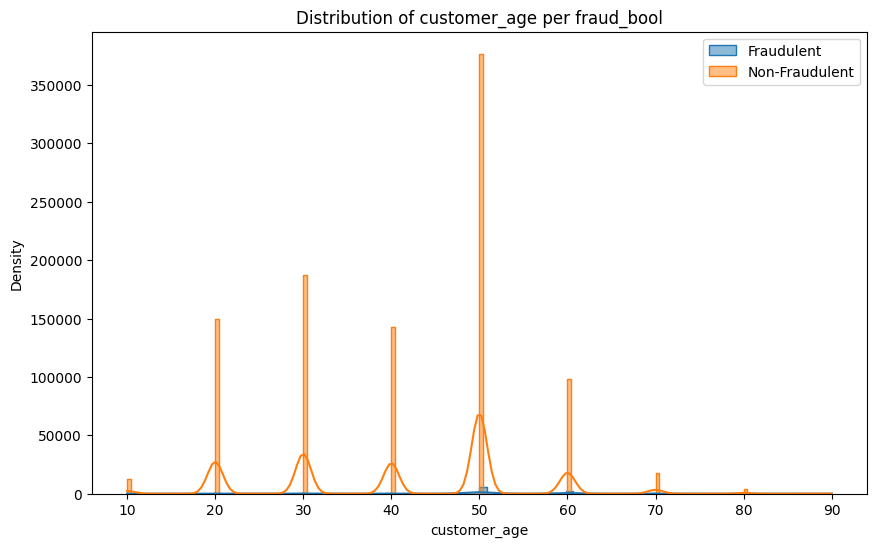

In [26]:
fraud_age = df2.loc[df2['fraud_bool'] == 1, 'customer_age']
nonfraud_age = df2.loc[df2['fraud_bool'] == 0]['customer_age']

plt.figure(figsize=(10, 6))
sns.histplot(fraud_age, kde=True, label='Fraudulent', element='step')
sns.histplot(nonfraud_age, kde=True, label='Non-Fraudulent', element='step')


plt.title('Distribution of customer_age per fraud_bool')
plt.xlabel('customer_age')
plt.ylabel('Density')
plt.legend()
plt.show() #do this plot again after upsampling

In [27]:
df2['customer_age'].value_counts()
df2['income'].value_counts()
df2['employment_status'].value_counts()

,count
employment_status,
CA,677869
CB,141784
CC,88937
CF,44833
CD,27328
CE,18758
CG,491


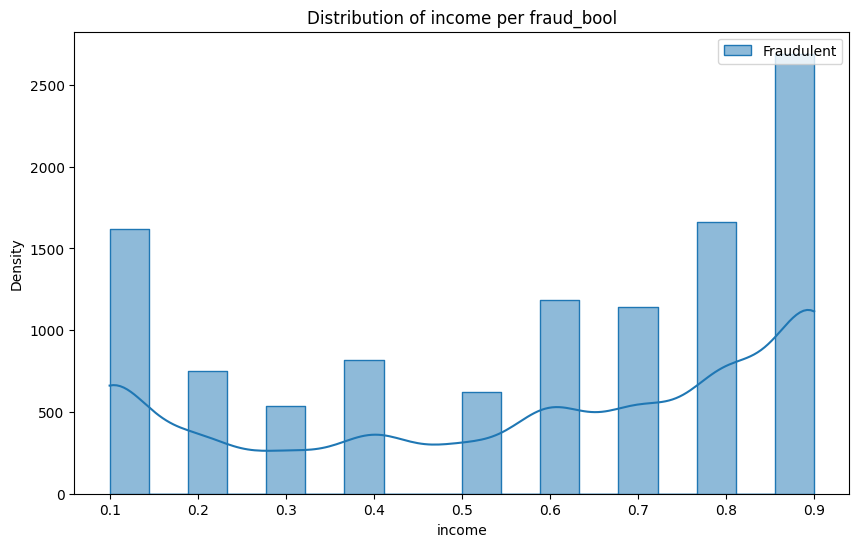

In [28]:
fraud_income = df2.loc[df1['fraud_bool'] == 1, 'income']
nonfraud_income = df2.loc[df1['fraud_bool'] == 0,'income']

plt.figure(figsize=(10, 6))
sns.histplot(fraud_income, kde=True, label='Fraudulent', element='step')
sns.histplot()

plt.title('Distribution of income per fraud_bool')
plt.xlabel('income')
plt.ylabel('Density')
plt.legend()
plt.show()

# Pre-process

Upsample to deal with imbalanced dataset

In [29]:
df2_frauds = pd.DataFrame(df1['fraud_bool'].value_counts())
print(df2_frauds)

             count
fraud_bool        
0           988971
1            11029


In [30]:
def upsample_minority_classes(dfs, target_column, minority_ratio=0.1, random_state=42):
    """
    Upsample the minority class proportional to the majority class

    Parameters:
    - dfs (list): List of pandas DataFrames to process.
    - target_column (str): The name of the column containing the target labels (e.g., 'fraud_bool').
    - minority_ratio (float): The desired ratio of minority samples to majority samples. Default is 0.1.
    - random_state (int): Random seed for reproducibility. Default is 42.

    Returns:
    - list: A list of DataFrames with the minority class upsampled.
    """
    upsampled_dfs = []

    for df in dfs:
        # Split into majority and minority classes
        df_majority = df[df[target_column] == 0]
        df_minority = df[df[target_column] == 1]

        # Calculate the number of samples for upsampling
        #n_samples = int(minority_ratio * len(df_majority) / (1 - minority_ratio))
        n_samples = len(df_majority) # choose for equal class sizes

        # Upsample minority class
        df_minority_upsampled = resample(
            df_minority,
            replace=True,
            n_samples=n_samples,
            random_state=random_state
        )

        # Combine majority and upsampled minority classes
        df_upsampled = pd.concat([df_majority, df_minority_upsampled])

        # Add the upsampled dataframe to the list
        upsampled_dfs.append(df_upsampled)

    return upsampled_dfs

In [31]:
dfb_up = upsample_minority_classes([dfb], target_column="fraud_bool", minority_ratio=0.1)[0]
df1_up = upsample_minority_classes([df1], target_column="fraud_bool", minority_ratio=0.1)[0]
df2_up = upsample_minority_classes([df2], target_column="fraud_bool", minority_ratio=0.1)[0]
df3_up = upsample_minority_classes([df3], target_column="fraud_bool", minority_ratio=0.1)[0]
df4_up = upsample_minority_classes([df4], target_column="fraud_bool", minority_ratio=0.1)[0]
df5_up = upsample_minority_classes([df5], target_column="fraud_bool", minority_ratio=0.1)[0]

# store upsampled DataFrames in dict
upsampled_dfs = {
    'Base': dfb_up,
    'Variant I': df1_up,
    'Variant II': df2_up,
    'Variant III': df3_up,
    'Variant IV': df4_up,
    'Variant V': df5_up
}

In [32]:
print(df2_up.fraud_bool.value_counts())

fraud_bool
0    988971
1    988971
Name: count, dtype: int64


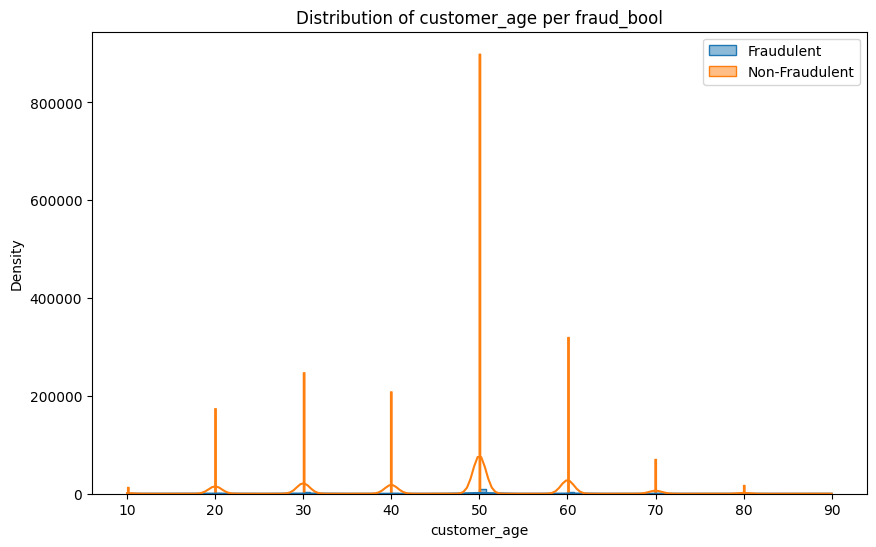

In [33]:
fraud_age_up = df2_up.loc[df1['fraud_bool'] == 1, 'customer_age']
nonfraud_age_up = df2_up.loc[df1['fraud_bool'] == 0]['customer_age']

plt.figure(figsize=(10, 6))
sns.histplot(fraud_age_up, kde=True, label='Fraudulent', element='step')
sns.histplot(nonfraud_age_up, kde=True, label='Non-Fraudulent', element='step')


plt.title('Distribution of customer_age per fraud_bool')
plt.xlabel('customer_age')
plt.ylabel('Density')
plt.legend()
plt.show() #do this plot again after upsampling

# Get the Errors

In [34]:
# Splitting data into train and test sets
'''train_dfs = {key: upsampled_dfs[upsampled_dfs["month"] < 6].sample(frac=1, replace=False)
                 for key, upsampled_dfs in dataframes.items()}
test_dfs = {key: upsampled_dfs[upsampled_dfs["month"] >= 6].sample(frac=1, replace=False)
                for key, upsampled_dfs in dataframes.items()}'''

train_dfs = {key: df[df["month"] < 6].sample(frac=1, replace=False)
for key, df in upsampled_dfs.items()}
test_dfs = {key: df[df["month"] >= 6].sample(frac=1, replace=False)
    for key, df in upsampled_dfs.items()}


In [35]:
def get_errors(model, label, test_dfs, upsampled_df):
    """Get errors from the 'best' LightGBM models and upsampled data
    - model: best trained LightGBM on all data variants
    - test_dfs (dict): Dictionary containing test DF
    - upsampled_dfs (dict): Dictionary containing upsampled DF for variants
    """

    # Prepare test data
    X_test = test_dfs[label].drop(columns=["fraud_bool"])
    Y_test = test_dfs[label]["fraud_bool"]

    # Encode categorical features
    label_encoder = LabelEncoder()
    for col in categorical_features:
        if col in X_test.columns:
            X_test[col] = label_encoder.fit_transform(X_test[col])

    # Predictions
    Y_pred = model.predict(X_test)
    Y_prob = model.predict_proba(X_test)[:, 1]

    # Create a predictions DataFrame
    predictions = pd.DataFrame({
        'predicted_class': Y_pred,
        'true_class': Y_test
    }, index=X_test.index)
    predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

    # Merge predictions (including errors) back into upsampled_df
    upsampled_df = upsampled_df.merge(predictions[['errors']], how='left', left_index=True, right_index=True)

    # Metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='binary')
    roc_auc = roc_auc_score(Y_test, Y_prob)
    conf_matrix = confusion_matrix(Y_test, Y_pred)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    return upsampled_df

   # Plot confusion matrix
    '''plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()'''

In [ ]:
# Call the function for each variant
#upsampled_dfs['Base'] = get_errors(modelb, 'Base', test_dfs, upsampled_dfs['Base'])
#upsampled_dfs['Variant I'] = get_errors(modelv1, 'Variant I', test_dfs, upsampled_dfs['Variant I'])
upsampled_dfs['Variant II'] = get_errors(modelv2, 'Variant II', test_dfs, upsampled_dfs['Variant II'])
#upsampled_dfs['Variant III'] = get_errors(modelv3, 'Variant III', test_dfs, upsampled_dfs['Variant III'])
#upsampled_dfs['Variant IV'] = get_errors(modelv4, 'Variant IV', test_dfs, upsampled_dfs['Variant IV'])



[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [ ]:
upsampled_dfs['Variant II'].info()

Add the metrics and errors to all variants

# Get the error labels

In [ ]:
'''def add_error_labels(df):
    df['TP'] = ((df['true_class'] == 1) & (df['predicted_class'] == 1)).astype(int)
    df['TN'] = ((df['true_class'] == 0) & (df['predicted_class'] == 0)).astype(int)
    df['FN'] = ((df['true_class'] == 1) & (df['predicted_class'] == 0)).astype(int)
    df['FP'] = ((df['true_class'] == 0) & (df['predicted_class'] == 1)).astype(int)
    return df

# Apply the function to each error dataset
dfb_err = add_error_labels(dfb_up)
df1_err = add_error_labels(df1_up)
df2_err = add_error_labels(df2_up)
df3_err = add_error_labels(df3_up)
df4_err = add_error_labels(df4_up)
df5_err = add_error_labels(df5_up)


In [ ]:
Base_error.head()
#Base_error.iloc[500]

In [ ]:
#Check if there are any FP/FN
#Base_error[Base_error['FN']==1]

# Add SHAP values on testset

In [ ]:
!pip install shap
import shap

 TreeExplainer is specifically optimized for tree-based models such as LightGBM, XGBoost, and CatBoost.

In [ ]:
X_train = (train_dfs[Base_error].drop(columns=["fraud_bool"]))


explainer = shap.TreeExplainer(modelb, X_train)